In [45]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
#We will use Yahoo Finance API to import ticker informations
import yfinance as yf


### 1. Introduction

It is the mark of a prudent investor to have some idea of the possible losses that may result from typical movements of financial markets. 

As part of the search for more transparecy in investments, there has gron up the concept of __Value at Risk (VaR)__ as a measure of the possible downside from an investment or portfolio

### 2. Definition

The value at risk is an estimate with a given degree of confidence, of how much one can lose over a given time horizon. In symbols, we can write this as

$$ \mathbb{P}(\delta V \leq  - VaR) = 1 - c$$

- VaR is computed assuming normal market circumstances. Extreme market conditions are not considered. 
- To compute it, we will need asset prices, volatility and correlation. 

### 3. Historical VaR

For this method it makes little difference whether we perform the calculations for a single stock or for a portfolio with a broader exposure. 

##### Definition
This method involves __calculating the portfolio's historical returns over a chosen time period and then ranking these returns from the worst to the best. The VaR is then determined by identifying the return that corresponds to the chosen level of confidence__, such as the 95th percentile, and multiplying it by the portfolio's current value.

##### Example
For example, if a portfolio has a value of 1 million dollars and the VaR at the 95th percentile is calculated to be 100,000 USD using the historical method, this means that there is a 5% chance that the portfolio may experience losses greater than $100,000 over the chosen time period.


##### Pros

- Simplicity: The historical method is relatively straightforward and easy to implement, as it only requires historical data and basic statistical calculations.
- Real-world data: Usage of actual historical market data to estimate the potential losses can make it more realistic than other methods that rely on assumptions or models.
- Flexibility: This method has the capacity to adapt to different time horizons and confidence levels, depending on the user's needs.

##### Cons

- Limitations: Based on past market conditions and may not reflect future market behavior or unforeseen events, which can lead to inaccurate VaR estimates.
- Shortcomings: The historical method does not account for extreme events that may not have occurred in the past, such as "black swan" events, which can result in underestimating the true risk.
- Sensitivity to data quality: The quality of the historical data used in the method can greatly affect the VaR calculations, and the method may not work well if the data is incomplete or biased.

[*********************100%***********************]  7 of 7 completed


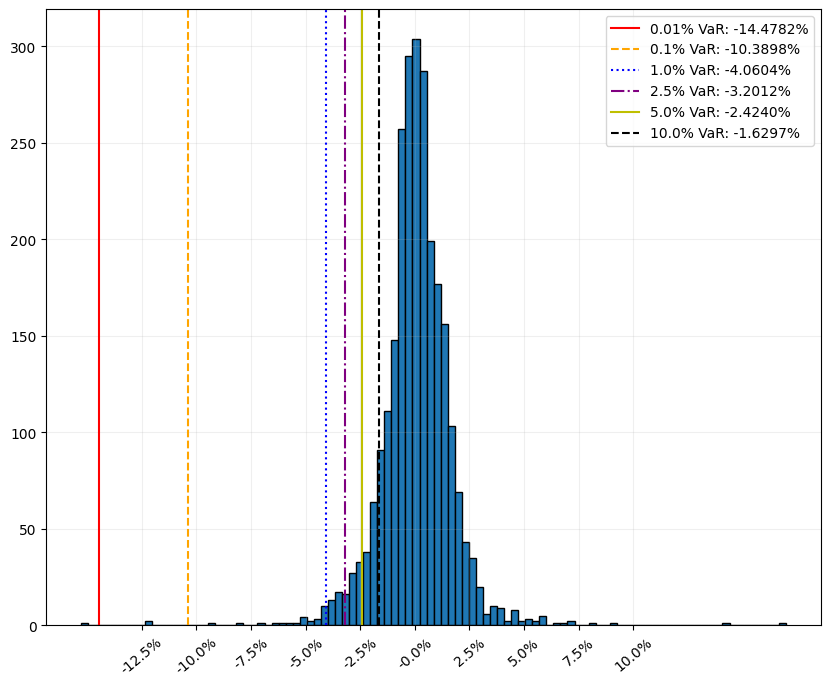

In [97]:
def historical_var(start_date = dt.date(year = 2013 , month = 1 ,day = 1),
                    tickers = ['GS','MS','JPM','C', 'MSFT','BAC', 'WFC'],
                    weights = "Equally Weighted",
                    period = "D",
                   confidence_levels=[0.01,0.1,1.0,2.5,5.0,10.0],
                   plotting = True
                   ):
######## STEP 1: We define weights and number of days and time horizon for our historical VaR.
    if period =="W": period_frame = 5
    elif period == "M": period_frame = 20
    elif period =="Y": period_frame = 252
    else: period_frame = 1
    if weights == "Equally Weighted":
        weights = np.full(len(tickers), 1/len(tickers))
######## STEP 2: Retrieving data from tickers from 2013 onwards.
    end_date = dt.date.today()
    price_data = pd.DataFrame(yf.download(tickers, start = start_date,
    end = end_date)['Close']).dropna().round(2)
######## STEP 3: Cleaning data and computing portfolio returns.
    returns = price_data.pct_change(periods=period_frame).dropna().round(4)
    portfolio_returns = returns.dot(weights)
    portfolio_returns = portfolio_returns.sort_values(ascending = True)
     #empty list to append the different VaR values
    rows = []
######## STEP 4: VaR will be the percentile on returns dataframe for each confidence interval.
    for i in range(len(confidence_levels)):
        VaR = np.percentile(portfolio_returns, confidence_levels[i])
        rows.append([str(confidence_levels[i])+'%', '{:.3f}%'.format(VaR*100)])
######## STEP 5: Plot empirical distribution and historical VaR for different confidence intervals.
    if plotting:
        plt.rcParams["figure.figsize"] = (10, 8)
        plt.hist(portfolio_returns, bins=100, edgecolor='black')
        colors = ['r','orange','b', 'purple','y', 'black']
        linestyle_str = ['-', '--',':','-.','-','--']
        for i in range(len(confidence_levels)):
            VaR = np.percentile(portfolio_returns, confidence_levels[i])
            label = '{}% VaR: {:.4f}%'.format(confidence_levels[i], VaR*100)
            plt.axvline(x=VaR, color=colors[i], linestyle=linestyle_str[i], label=label)
            plt.legend()
        xticks = np.arange(-0.125, 0.125, 0.025)
        xlabels = ['{:.1f}%'.format(element*100) for element in xticks]
        plt.grid(True,alpha=0.2)
        plt.xticks(ticks = xticks, labels = xlabels, rotation = 40)
        plt.show()
    return portfolio_returns, rows

L = historical_var()

### 4.Parametric Method: VaR For a single asset

$\delta V = R_t \Delta S$, with $S$ being the current asset price and $\Delta$ being our position in stock. __For this method, we will assume $R_t$ follows a normal distribution with mean $\mu \times \delta t$ and standard deviation $\sigma \times (\delta t)^{\frac{1}{2}}$__, with $\delta t$ being the time horizon.

Thus, if the time horizon is $\delta t$ and the required degree of confidence is $c$:  

$$VaR =  - S(\mu  \delta t + \sigma  (\delta t)^{\frac{1}{2}} \alpha (1 - c))$$

With $\alpha(.)$ being the inverse cdf for a standard normal distribution (e.g. 1.65 for 95% confidence, 1.96 for 97.5% confidence, and 2.33 for 99% confidence). 

[*********************100%***********************]  1 of 1 completed


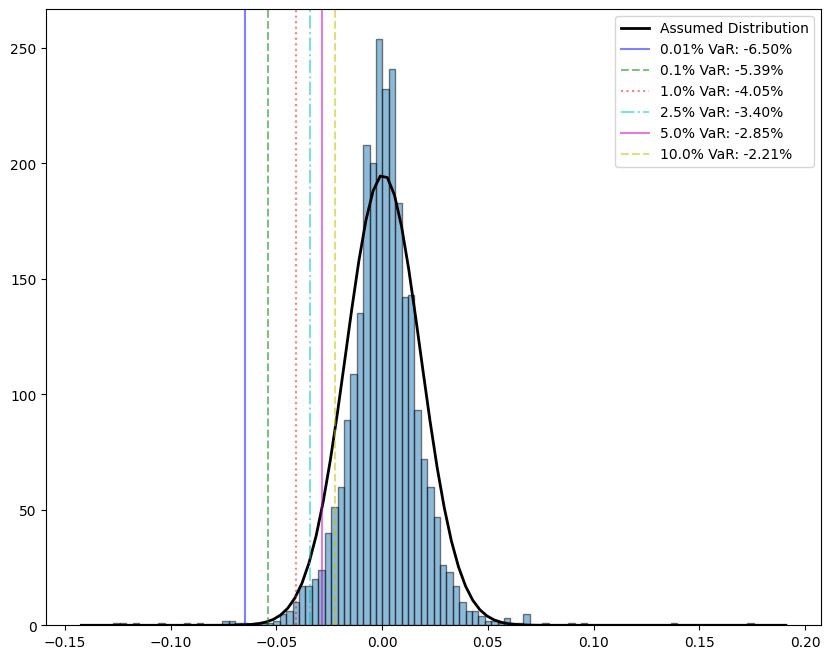

[-0.06502437979380422,
 -0.05394208290779744,
 -0.040478649280988384,
 -0.034021147372628964,
 -0.028467339484829577,
 -0.022064154677652745]

In [100]:
def Parametric_VaR_Stock(stock = 'GS',
                       period = 'D',
                       start_date = dt.date(year = 2013 , month = 1 ,day = 1),
                       confidence_levels = [0.0001, 0.001, 0.01,0.025, 0.05, 0.1],
                       plotting = True):
    if period =="W": period_frame = 5
    elif period == "M": period_frame = 20
    elif period =="Y": period_frame = 252
    elif period == "D": period_frame = 1
    price_df = yf.download(stock, start = start_date, end = dt.date.today())['Close']
    daily_returns_df = price_df.pct_change().dropna()
    period_returns_df = price_df.pct_change(period_frame).dropna()
    mu, std = norm.fit(daily_returns_df)
    mu = mu*period_frame
    std = std*math.sqrt(period_frame)
    VaRs = [norm.ppf(p, mu, std) for p in confidence_levels]
    if plotting:
        colors = "bgrcmykw"
        linestyle_str = ['-', '--',':','-.','-','--']
        plt.rcParams["figure.figsize"] = (10, 8)
        plt.hist(period_returns_df, bins=100, edgecolor='black',  alpha=.5)
        xmin, xmax = plt.xlim()
        bin_width = (xmax - xmin)/100
        N = len(period_returns_df)
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std) * N * bin_width
        plt.plot(x, p, 'k', linewidth=2, label = "Assumed Distribution")
        for i in range(len(confidence_levels)):
            VaR = VaRs[i]
            conf = confidence_levels[i]
            color = colors[i]
            style = linestyle_str[i]
            label = '{}% VaR: {:.2f}%'.format(conf*100, VaR*100)
            plt.axvline(x=VaR, color=colors[i], linestyle=linestyle_str[i], label=label, alpha = .5)
            plt.legend()
    plt.show()
    return VaRs
Parametric_VaR_Stock()

### 5.Parametric Method: VaR For a portfolio

If we know the volatilities of all the assets in our portfolio (consisting of $n$ assets with a weight of $\omega_i$ for the $i^{th}$ asset) and the correlations between them, then we can calculate the VaR for the whole portfolio. 

If the volatility of the $i^{th}$ asset in our portfolio is $\sigma_i$ and the correlation between the $i^{th}$ and the $j^{th}$ asset is $\rho_{ij}$ (with $\rho_{ii} = 1$), then return in our portfolio can be expressed as
$\delta R_P = \sum_{i = 1}^{n}\omega_i R_i \text{ for }R_i \sim \mathcal{N}(\mu_i, \sigma_i)$ follows a normal law with drift $\mu_{\delta R_P} = \delta t \sum_{i = 1}^{n} \omega_i \mu_i$, and variance $\sigma^2_{\delta R_P} = \delta t \sum_{i = 1}^{n}\sum_{j = 1}^{n}\omega_i \omega_j \sigma_i \sigma_j \rho_{ij}$. 


Thus, the VaR for the portfolio is:

$$VaR = -(\mu_{\delta R_P} + \sigma_{\delta R_P}\alpha (1 - c))$$

[*********************100%***********************]  7 of 7 completed


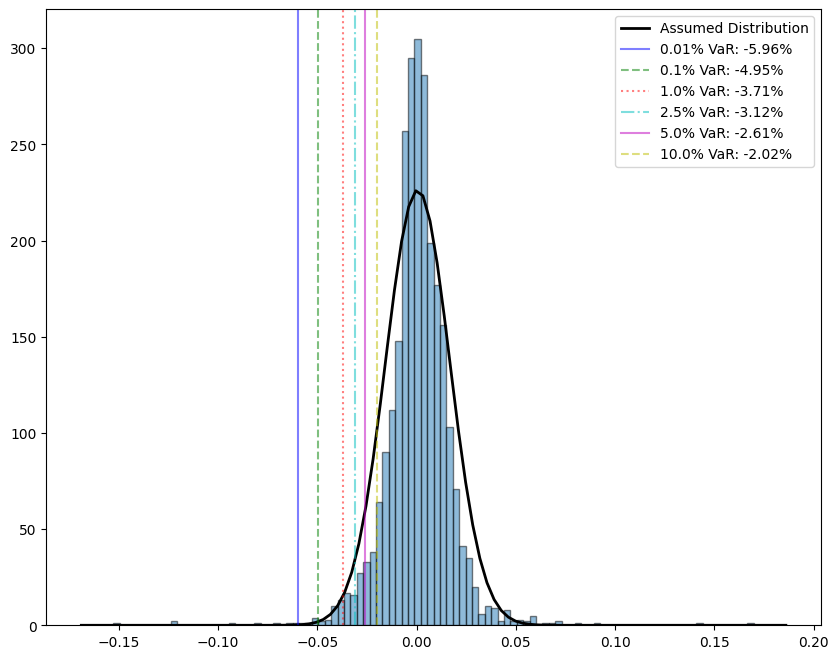

In [111]:
def Parametric_VaR_Portfolio(
    tickers = ['GS','MS','JPM','C', 'MSFT','BAC', 'WFC'],
    weights = "Equally Weighted",
    period = 'D',
    start_date = dt.date(year = 2013 , month = 1 ,day = 1),
    confidence_levels = [0.0001, 0.001, 0.01,0.025, 0.05, 0.1],
    plotting = True):
#STEP 1: If we want an equally weighted portfolio we define weights
    if weights == "Equally Weighted":
        weights = np.full(len(tickers), 1/len(tickers))
#STEP 2: Defining the period timeframe
    if period =="W": period_frame = 5
    elif period == "M": period_frame = 20
    elif period =="Y": period_frame = 252
    elif period == "D": period_frame = 1
#STEP 3: Importing data from Yahoo Finance
    price_df = yf.download(tickers, start = start_date, end = dt.date.today())['Close']
#STEP 4: Computing individual returns, averages and covariance matrix
    daily_returns_df = price_df.pct_change().dropna()
    mu = daily_returns_df.mean()
    C = daily_returns_df.cov()
#STEP 5: Computing the whole portfolio returns and variance
    portfolio_std = math.sqrt(period_frame*np.dot(weights, np.dot(C, weights.T)))
    portfolio_mu = period_frame*np.dot(weights, mu)
    portfolio_returns = (np.dot(daily_returns_df, weights))
    
    VaRs = [norm.ppf(p, portfolio_mu, portfolio_std) for p in confidence_levels]
    if plotting:
        colors = "bgrcmykw"
        linestyle_str = ['-', '--',':','-.','-','--']
        plt.rcParams["figure.figsize"] = (10, 8)
        plt.hist(portfolio_returns, bins=100, edgecolor='black',  alpha=.5)
        xmin, xmax = plt.xlim()
        bin_width = (xmax - xmin)/100
        N = len(portfolio_returns)
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, portfolio_mu, portfolio_std) * N * bin_width
        plt.plot(x, p, 'k', linewidth=2, label = "Assumed Distribution")
        for i in range(len(confidence_levels)):
            VaR = VaRs[i]
            conf = confidence_levels[i]
            color = colors[i]
            style = linestyle_str[i]
            label = '{}% VaR: {:.2f}%'.format(conf*100, VaR*100)
            plt.axvline(x=VaR, color=colors[i], linestyle=linestyle_str[i], label=label, alpha = .5)
            plt.legend()
    plt.show()
    return VaRs
L = Parametric_VaR_Portfolio()

### 5.Parametric Method: VaR for Derivatives

The key point about estimating a portfolio containing derivatives is that even if the change in the underlying is normal, the essential __non-linearity in derivatives means that the change in the derivative can be far from Normal__. Nevertheless, if we are concernced with very small movements in the underlying, for example over a very short period of time, we may be able to __approximate for the sensitivity of the portfolio to change in the underlying by the option's delta__.

For larger movements we may need to take higher-order aproximation. 

#### The Delta Approximation

Consider __a portfolio of derivatives with a single underlying $S$__. 

Assuming the returns of the underlying follow a normal law with mean $\mu \delta t$ and standard deviation $\sigma \delta t^{1/2}$. The deviation of the distribution of the underlying is $\sigma S \delta t^{1/2}$. 

If we assume that: 

$$\delta V = \Delta dS$$

then the standard deviation of the option position is 

$$\sigma S \delta t^{1/2} \Delta$$

$\Delta$ must be __the delta of the whole position__, the sensitivity of all relevant options to the particular underlying. Now if we expand it to a portfolio consisting of options on different underlyings, it is a small, and basic step, to have the following VaR estimate:

$$\delta V = \sum_{i = 1}^{n}\Delta_i dS_i \Rightarrow VaR = -\alpha (1 - c) \sqrt{\delta t \sum_{i = 1}^{n}\sum_{j = 1}^{n} \Delta_i\Delta_j \sigma_i \sigma_j \rho_{ij}S_i S_j}$$

#### The Delta/Gamma Approximation

The delta approximation may be suitable for small time horizons, or small movements in the underlying. A better approximation is achieved by going to higher order and __incorporate the convexity effect.__

Let us go through a little example. Suppose we have a portfolio consisting in an option on a stock. The relationship between the change in the underlying and the change in the value of the option is:

$$\delta V = \frac{\partial V}{\partial S} \delta S + \frac{1}{2}\frac{\partial ^2 V}{\partial S^2}\delta S^2 + \frac{\partial V}{\partial t} \delta t + \ldots$$

Since, in this parametic approach we are assuming that 
$$\delta S = \mu S \delta t + \sigma S \delta t^{1/2}\phi$$

where $\phi$ is drawn from a standardized normal distribution, we can write, 

$$\delta V = \Delta \sigma S \delta t^{1/2}\phi + \delta t \left(\Delta\mu S + \frac{1}{2}\Gamma \sigma^2 S^2 \phi^2 + \Theta \right) + \ldots$$

- To leading order, randomness in the option value is simply proportional to that in the underlying. 
- The gamma effect is to introduce a term that is non-linear in the random component of $\delta S$


#### Visualization

We will now visualize the difference in the probabilistic distributions of:
- the underlying asset
- A portfolio containing a European ATM call whose variations have only been approximated with the delta method.
- Same portfolio but with the delta/gamma method. 


In [8]:
def option_greeks(S, K, r, sigma, T):
    """
    Function computing Delta, Gamma and Theta for European Vanilla Options using BS formula. 
    
    input:
    S: Current underlying price. 
    K: Strike Price
    r: annualized risk-free rate
    sigma: annualized volatility of the asset
    T: Time to maturity (in years)
    
    output:
    Dictionnary containing greeks
    
    """
    
    d1 = (math.log(S/K) + (r + sigma**2/2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)

    N = lambda x: (1 + math.erf(x/math.sqrt(2))) / 2
    Nd1 = N(d1)
    Nd2 = N(d2)

    Nd1n = lambda x: math.exp(-x**2/2) / math.sqrt(2*math.pi)
    nd1 = Nd1n(d1)

    call_delta = Nd1
    put_delta = Nd1 - 1

    call_gamma = nd1 / (S * sigma * math.sqrt(T))
    put_gamma = call_gamma

    call_theta = -(S * nd1 * sigma / (2 * math.sqrt(T))) - (r * K * math.exp(-r*T) * Nd2)
    put_theta = -(S * nd1 * sigma / (2 * math.sqrt(T))) + (r * K * math.exp(-r*T) * (1 - Nd2))

    return {
        "call_delta": call_delta,
        "put_delta": put_delta,
        "call_gamma": call_gamma,
        "put_gamma": put_gamma,
        "call_theta": call_theta / 365,
        "put_theta": put_theta / 365
    }

################# USE CASE ####################

#ATM Call
#S = 100
#K = 100
#r = 0.05
#sigma = 0.2
#Maturity: 3M
#T = 0.25

#greeks = option_greeks(S, K, r, sigma, T)
#print(greeks)

In [21]:
def plot_empirical(data_list, labels=None):
    """
    Esta función grafica varias distribuciones empíricas en la misma ventana.
    """
    # Configurar el subplot
    fig, ax = plt.subplots()

    # Iterar sobre cada array de datos y graficar la curva de densidad de kernel correspondiente
    for i, data in enumerate(data_list):
        if labels:
            sns.kdeplot(data, shade=True, ax=ax, label=labels[i])
        else:
            sns.kdeplot(data, shade=True, ax=ax)

    # Configurar las etiquetas del gráfico
    ax.set(xlabel='Value', ylabel='Density', title='Empirical Distribution')
    ax.legend()

    plt.show()

In [39]:
def plot_portfolio_distributions(
    mu,
    sigma,
    S = 100,
    period = 'D',
    option_type = "call",
    r = 0.05,
    K = 100,
    option_maturity = 0.25):
    
    #First, computing VaR timeframe
    if period =="W": period_frame = 1/52
    elif period == "M": period_frame = 1/12
    elif period =="Y": period_frame = 1
    elif period == "D": period_frame = 1/252
    
    #Compute greeks on our option position
    greeks = option_greeks(S, K, r, sigma, T = option_maturity)
    Delta = greeks[f"{option_type}_delta"]
    Gamma = greeks[f"{option_type}_gamma"]
    Theta = greeks[f"{option_type}_theta"]
    #Generate random normal variables
    L = np.random.normal(size = 100000)
    S_Change = [mu * S * period_frame + sigma*S*math.sqrt(period_frame)*element for element in L]
    V_Change_Delta = [Delta*element*(mu*S*period_frame + sigma*S*math.sqrt(period_frame)) for element in L]

    V_Change_Gamma = [Delta * sigma*S*math.sqrt(period_frame)*element + period_frame*(Delta*mu*S + 0.5*Gamma*sigma**2*S**2*element**2 + Theta) for element in L]
    plotting = [S_Change, V_Change_Delta, V_Change_Gamma]
    plot_empirical(plotting, labels=["Underlying", "Delta", "Delta + Gamma"])
    return V_Change_Delta
    

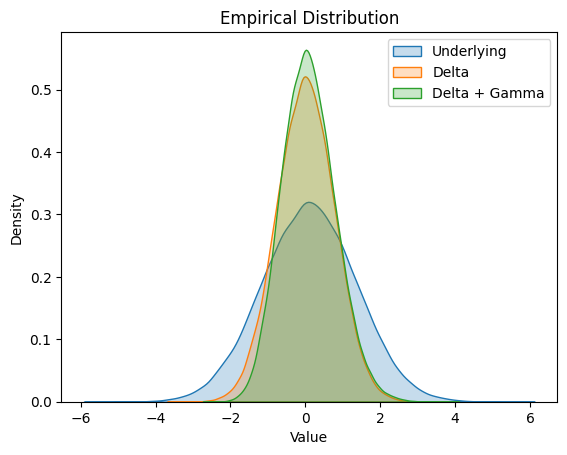

In [40]:
L = plot_portfolio_distributions(mu = 0.25, sigma= 0.20)

In [50]:
d1 = (math.log(0.91)+0.02)/0.141
d2 = d1 - 0.2*math.sqrt(1/2)

print(math.exp(-0.01*1/2)*100 * norm.cdf(d1) - 110*math.exp(-0.03*1/2)*norm.cdf(d2))

2.460534513432396


In [51]:
norm.cdf(-1)

0.15865525393145707